<b><h1>Books Recommendation System

In [484]:
import re
import pickle
import joblib
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import save_npz
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

<b><h3>Dataset

In [485]:
books = pd.read_csv("../data/BX_Books.csv", delimiter=';',encoding='ISO-8859-1', on_bad_lines='skip')
users = pd.read_csv("../data/BX-Users.csv", delimiter=';',encoding='ISO-8859-1', on_bad_lines='skip')
ratings = pd.read_csv("../data/BX-Book-Ratings.csv", delimiter=';',encoding='ISO-8859-1', on_bad_lines='skip')

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271379, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


<b><h3>Pre-processing

<b>Books Dataset Pre-processing

In [486]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [487]:
## Drop URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271377 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB


In [488]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


In [489]:
books.isnull().sum() 

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
dtype: int64

In [490]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
118038,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187700,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing


In [491]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129043,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [492]:
books.at[118038 ,'Book-Author'] = 'Other'
books.at[187700 ,'Book-Author'] = 'Other'

books.at[128896 ,'Publisher'] = 'Other'
books.at[129043 ,'Publisher'] = 'Other'

In [493]:
## Checking for column Year-of-publication
unique_years_array = books['Year-Of-Publication'].unique()
sorted_years = np.array(sorted([year for year in unique_years_array]))
print(sorted_years)

[   0 1376 1378 1806 1897 1900 1901 1902 1904 1906 1908 1909 1910 1911
 1914 1917 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930
 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944
 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958
 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2008 2010 2011 2012 2020 2021 2024 2026
 2030 2037 2038 2050]


In [494]:
pd.set_option('display.max_colwidth', None)

In [495]:
books.loc[books['Year-Of-Publication'] == 0,:].head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
176,3150000335,Kabale Und Liebe,Schiller,0,"Philipp Reclam, Jun Verlag GmbH"
188,342311360X,Die Liebe in Den Zelten,Gabriel Garcia Marquez,0,Deutscher Taschenbuch Verlag (DTV)
288,0571197639,Poisonwood Bible Edition Uk,Barbara Kingsolver,0,Faber Faber Inc
351,3596214629,"Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,0,Fischer Taschenbuch Verlag GmbH
542,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda Del Fiume Piedra,P Coelho,0,Fabbri - RCS Libri


In [496]:
print(str(books['Year-Of-Publication'].count()))

271379


In [497]:
## Replacing Invalid years with year has most books published
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [498]:
books.loc[books['Year-Of-Publication'] > 2020, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [499]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [500]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [501]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271066 entries, 0 to 271065
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271066 non-null  object
 1   Book-Title           271066 non-null  object
 2   Book-Author          271066 non-null  object
 3   Year-Of-Publication  271066 non-null  int64 
 4   Publisher            271066 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


<b>Users Dataset Pre-processing

In [502]:
print("Columns: ", list(users.columns))
users.info()
users.head()

Columns:  ['User-ID', 'Location', 'Age']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [503]:
print(users.isna().sum())               

User-ID          0
Location         0
Age         110762
dtype: int64


In [504]:
## Check for all values present in Age column
unique_ages_array = users['Age'].unique()
sorted_ages = np.array(sorted([age for age in unique_ages_array]))
print(sorted_ages)

[ nan   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 113. 114. 115. 116. 118. 119. 123. 124. 127. 128. 132. 133. 136.
 137. 138. 140. 141. 143. 146. 147. 148. 151. 152. 156. 157. 159. 162.
 168. 172. 175. 183. 186. 189. 199. 200. 201. 204. 207. 208. 209. 210.
 212. 219. 220. 223. 226. 228. 229. 230. 231. 237. 239. 244.]


In [505]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]

In [506]:
mean = round(required['Age'].mean())   
mean

35

In [507]:
users.loc[users['Age'] > 80, 'Age'] = mean
users.loc[users['Age'] < 10, 'Age'] = mean
users['Age'] = users['Age'].fillna(mean)
users['Age'] = users['Age'].astype(int)

In [508]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_city = 0 
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  # Removing invalid entries
        city.append('other')
        count_no_city += 1
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

tmp_city = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    tmp_city.append(c[0])

tmp_state = []
for ent in state:
    c = ent.split('/')
    tmp_state.append(c[0])

df_city = pd.DataFrame(tmp_city,columns=['City'])
df_state = pd.DataFrame(tmp_state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_city)
print(count_no_country)
print(count_no_state)

561
4659
16044


In [509]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [510]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


In [511]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


<b>Books-Ratings Dataset Pre-processing

In [512]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [513]:
## Checking for null values
ratings.isnull().sum() 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [514]:
## Checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [515]:
## Checking User-ID contains only number or not
print(is_numeric_dtype(ratings['User-ID']))

True


In [516]:
## Checking ISBN
flag = 0
k = []
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [517]:
## Removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist() 
reg = "[^A-Za-z0-9]" 
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])    
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [518]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [519]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [566]:
ratings.to_csv("../data/ratings_cleaned.csv", index=False)
ratings.info()
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


<h3><b>Merging of all three Tables

<b>Merging Books, Users and Rating Tables in One

In [521]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031648 entries, 0 to 1031647
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031648 non-null  object
 1   Book-Title           1031648 non-null  object
 2   Book-Author          1031648 non-null  object
 3   Year-Of-Publication  1031648 non-null  int64 
 4   Publisher            1031648 non-null  object
 5   User-ID              1031648 non-null  int64 
 6   Book-Rating          1031648 non-null  int64 
 7   Age                  1031648 non-null  int64 
 8   City                 1031648 non-null  object
 9   State                1031648 non-null  object
 10  Country              1031648 non-null  object
dtypes: int64(4), object(7)
memory usage: 86.6+ MB


<b>Divide complete data on the basis of Implicit and Explicit ratings datasets

In [522]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384084, 11)

In [523]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647564, 11)

In [524]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8,35,other,other,other
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,67544,8,30,toronto,ontario,canada
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,116866,9,35,ottawa,other,other
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,123629,9,35,kingston,ontario,canada


<h3><b>Data Visualization

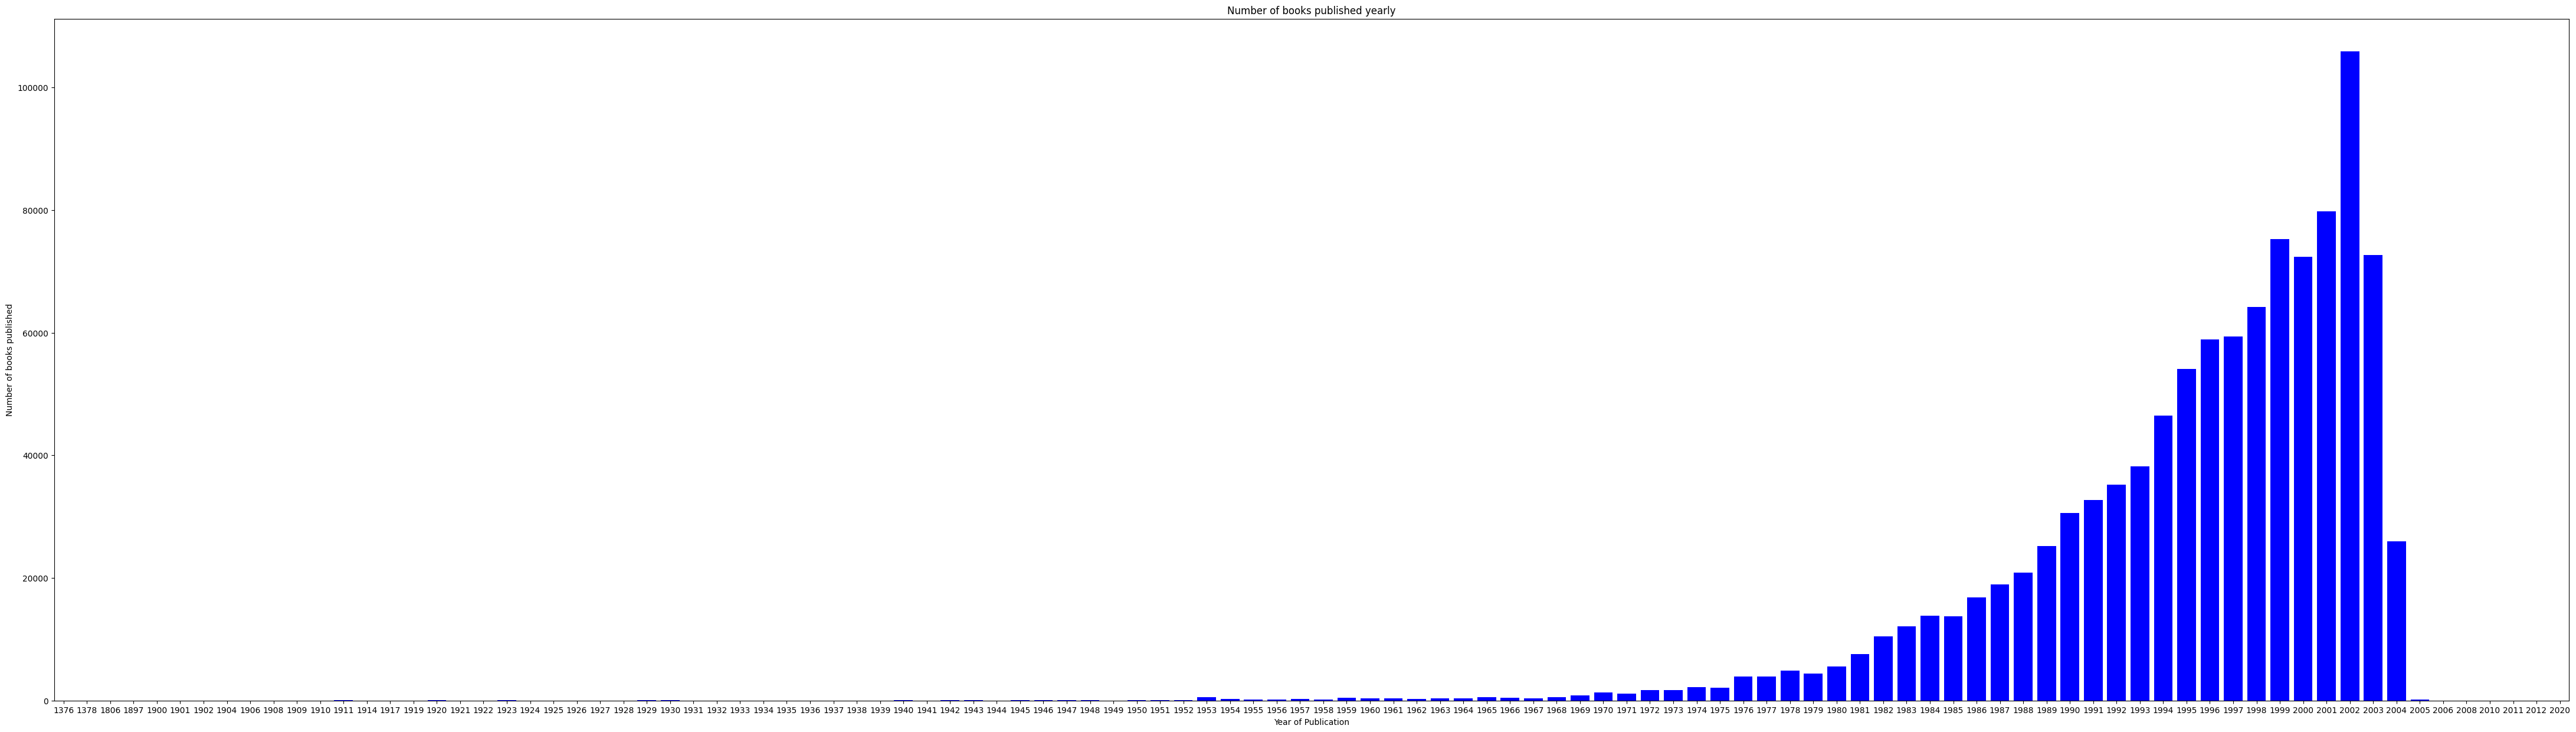

In [525]:
publications = {}
for year in dataset['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'Number of books by an author (Top 15)')

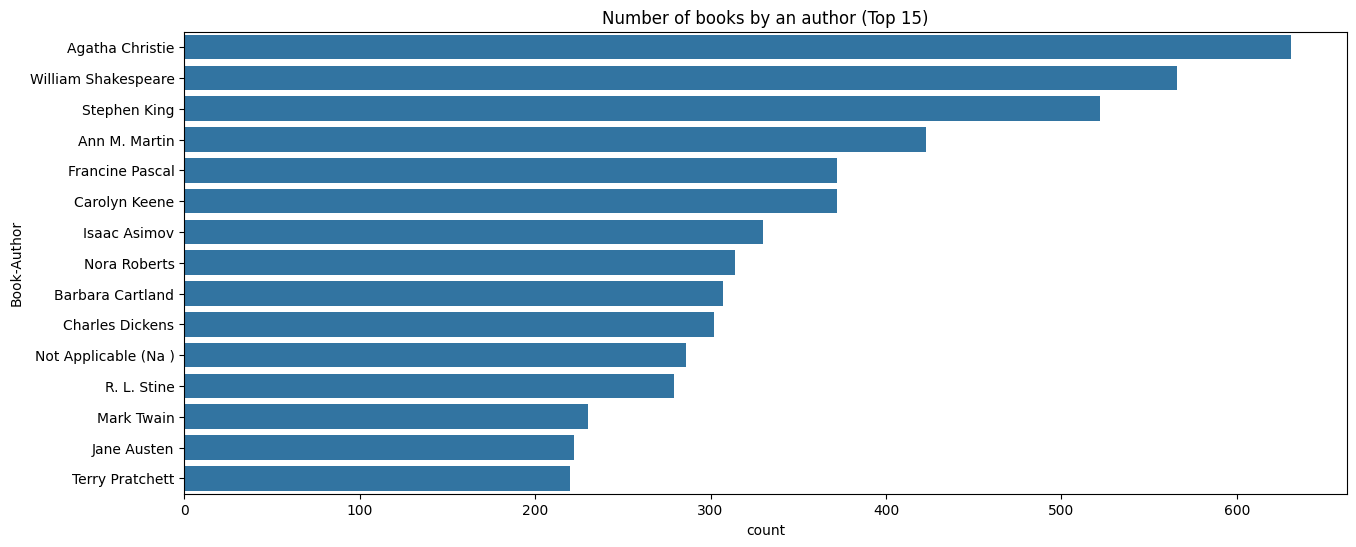

In [526]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("Number of books by an author (Top 15)")

Text(0.5, 1.0, 'Number of books published by a publisher (Top 15)')

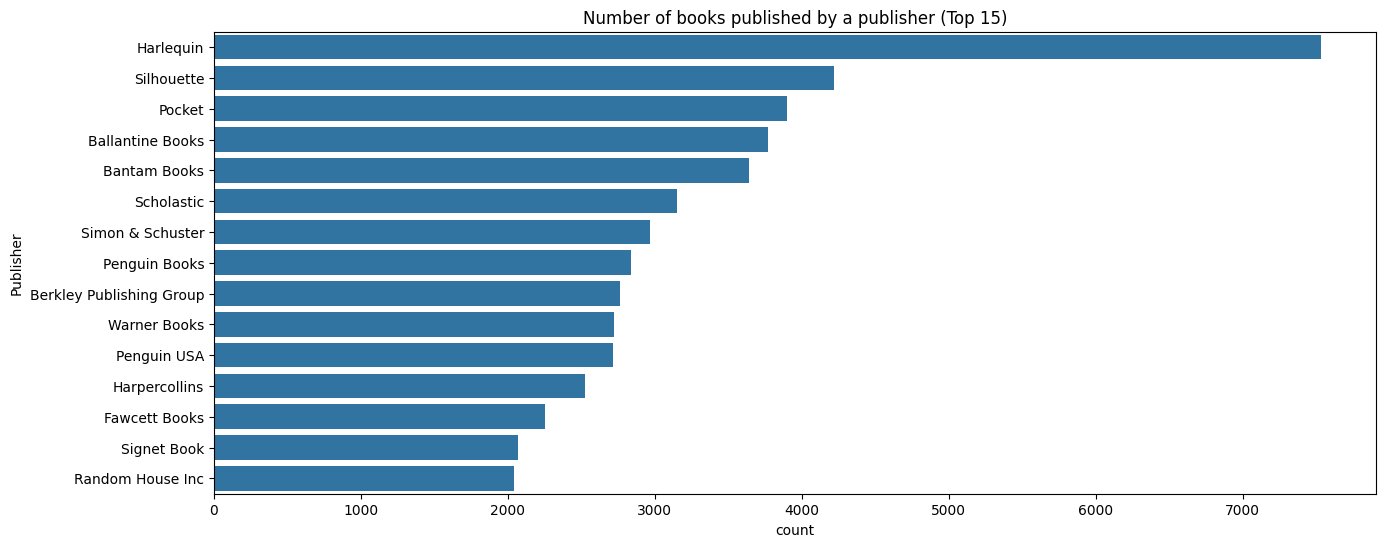

In [527]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("Number of books published by a publisher (Top 15)")

<Axes: xlabel='Book-Rating', ylabel='count'>

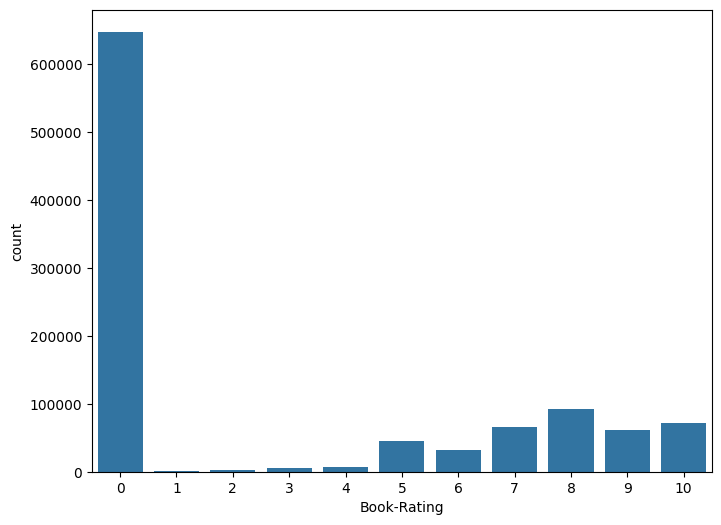

In [528]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=dataset)

Text(0.5, 1.0, 'Explicit Ratings')

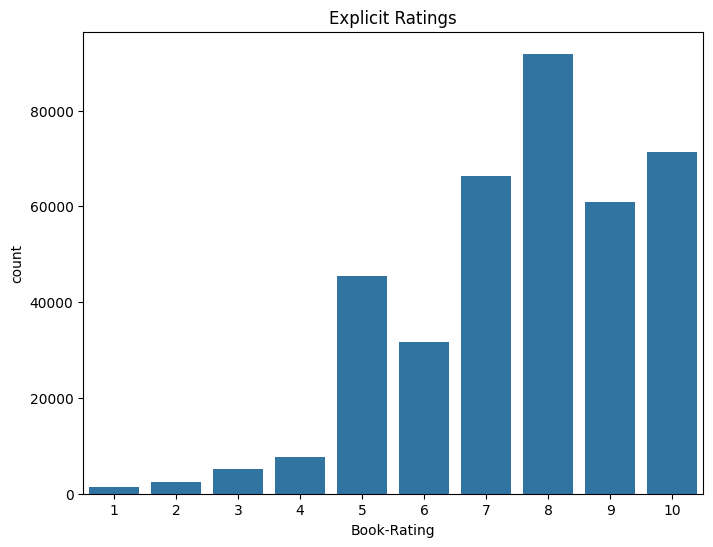

In [529]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = dataset[dataset['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

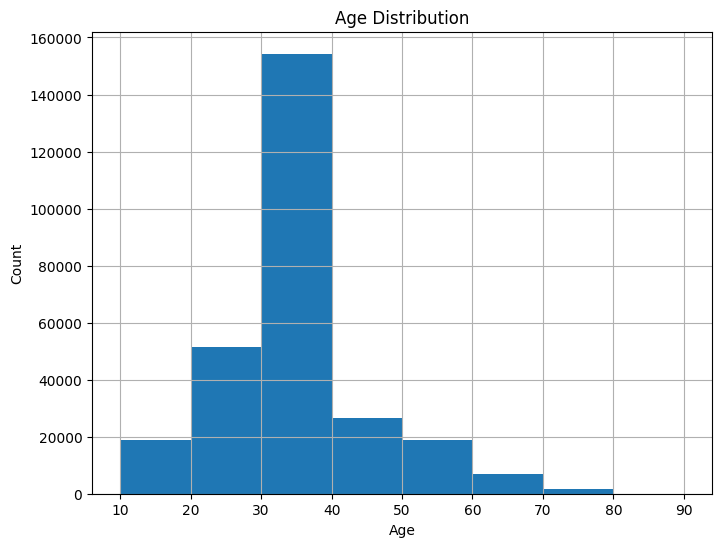

In [530]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Number of readers from each city (Top 15)')

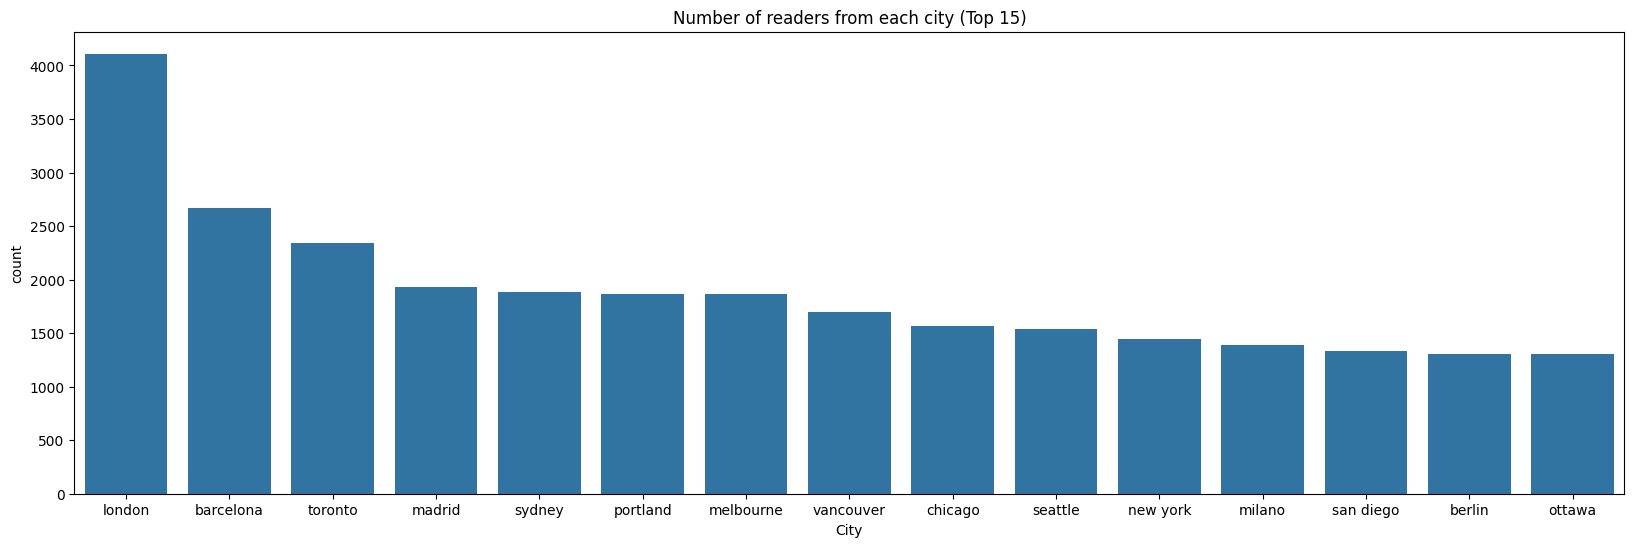

In [531]:
plt.figure(figsize=(20,6))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:15])
plt.title("Number of readers from each city (Top 15)")

Text(0.5, 1.0, 'Number of readers from each state (Top 15)')

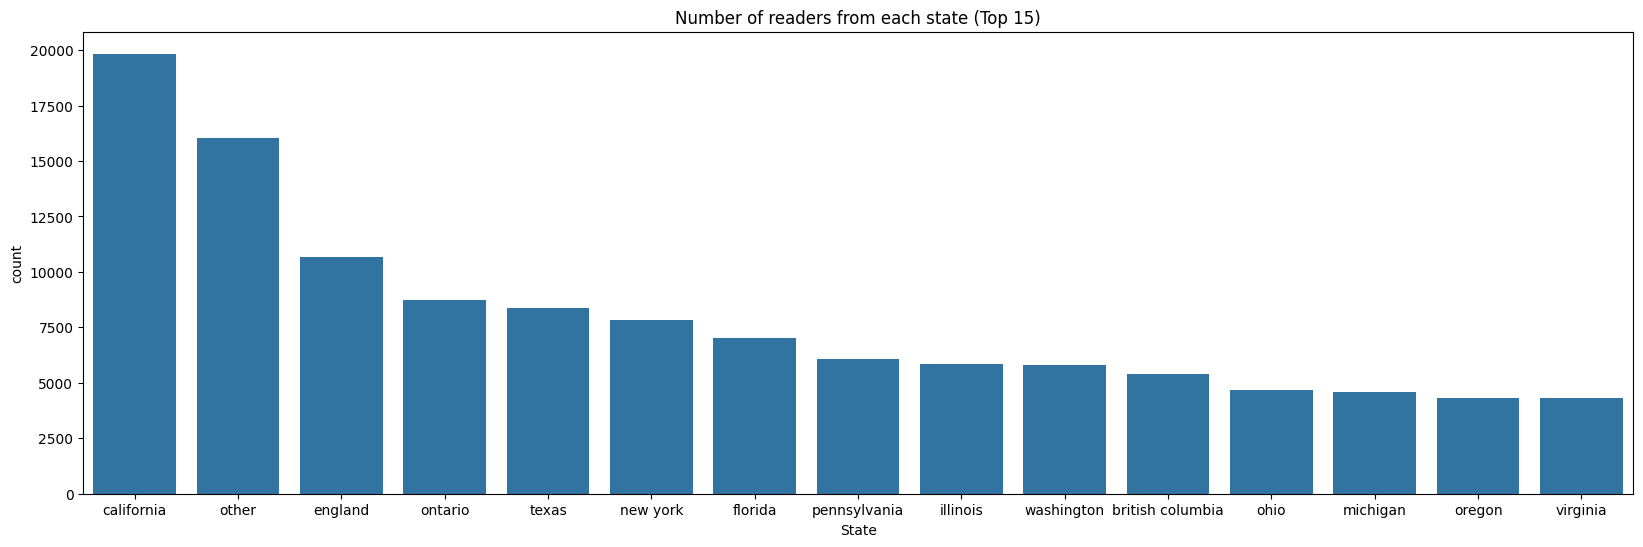

In [532]:
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("Number of readers from each state (Top 15)")

Text(0.5, 1.0, 'Number of readers from each country (Top 10)')

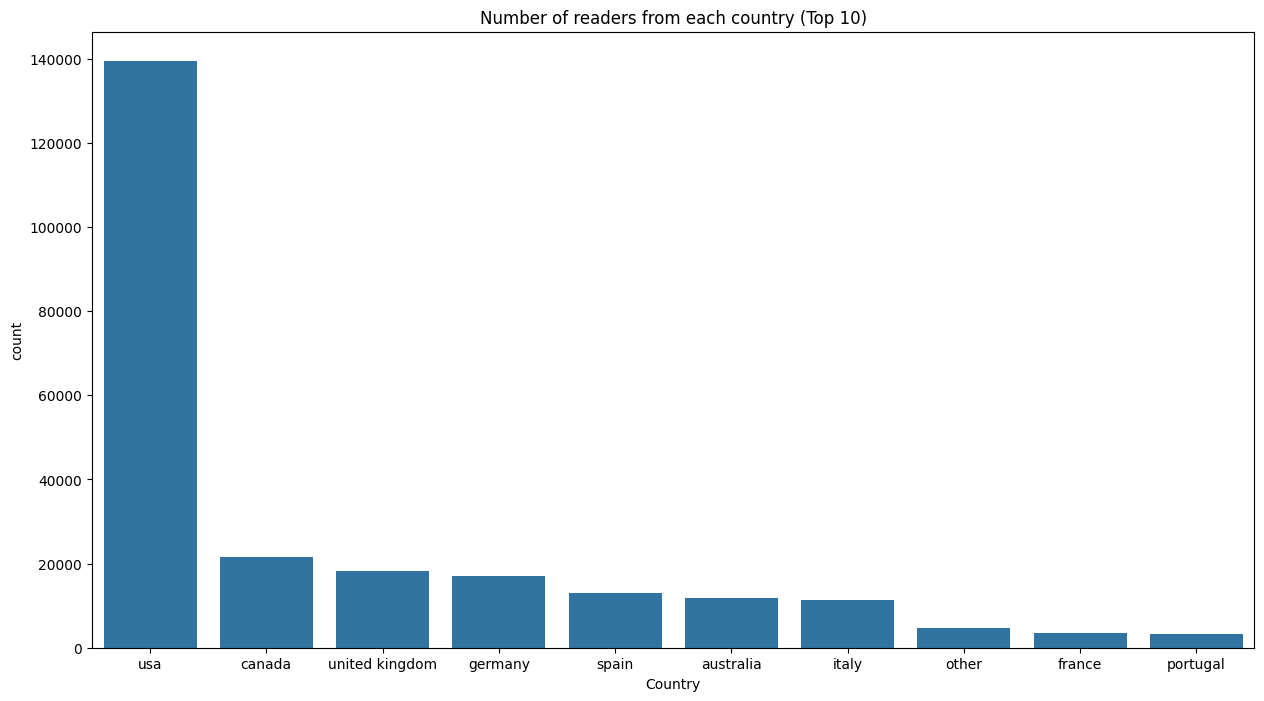

In [533]:
plt.figure(figsize=(15,8))
sns.countplot(x="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("Number of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

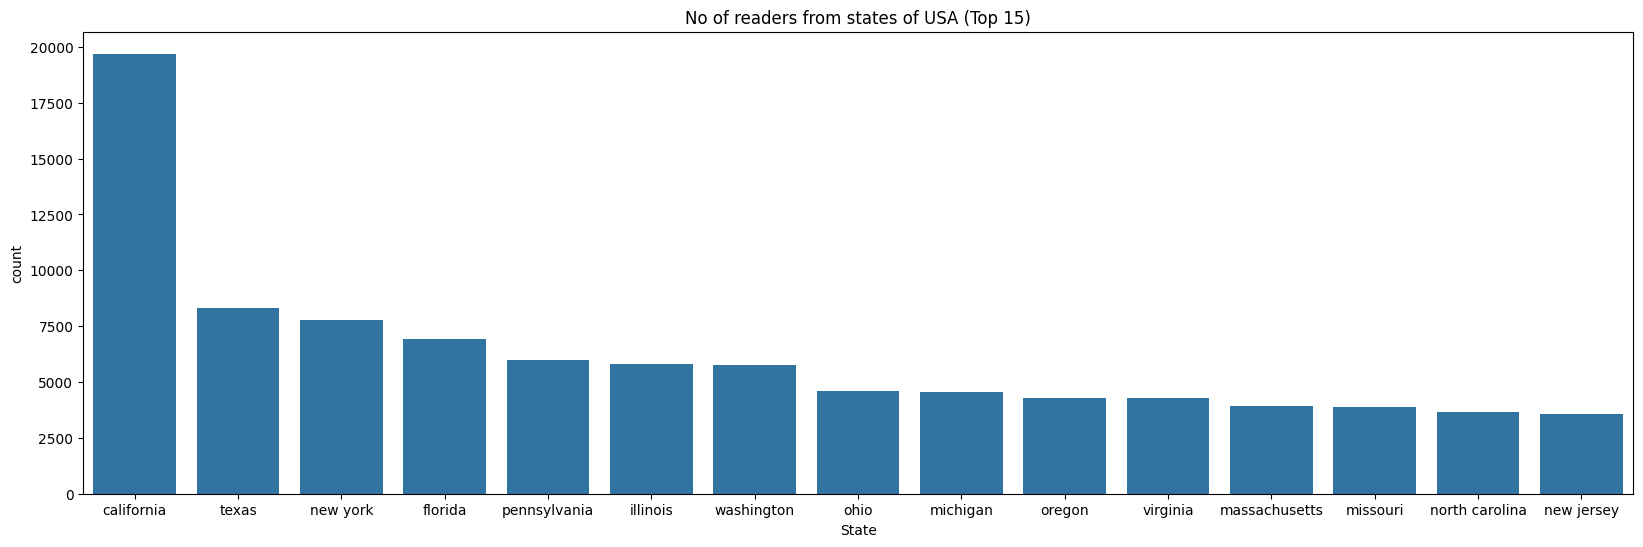

In [534]:
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

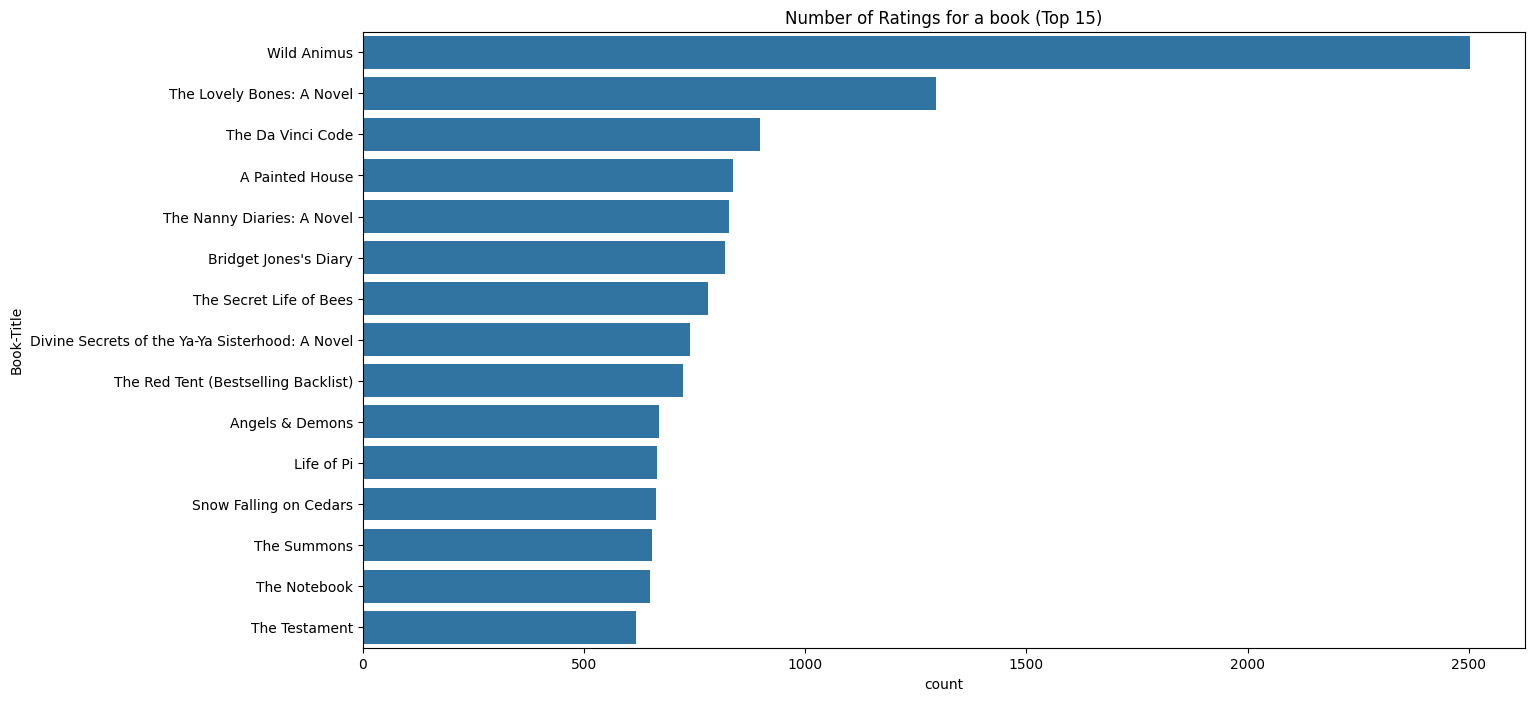

In [535]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

<h2><b>Recommendation Systems

In [536]:
# bookName = input("Enter a book name: ")
# number = int(input("Enter number of books to recommend: "))
bookName = "The Kitchen God's Wife"
number = 5
# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

<h5><b> 1. Popularity Based (Top In whole collection)

In [537]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        result = pd.merge(data, books, on='ISBN', how='inner')
        return result
    return "Invalid number of books entered!!"

In [538]:
print("Top", number, "Popular books are: ")
popularity_based(dataset1, number)

Top 5 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far
2,0385504209,488,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial


<h5><b>2. Popularity Based (Top In a given place)

In [539]:
def search_unique_places(dataframe, place):
    place = place.lower()

    if place in list(dataframe['City'].unique()):
        return dataframe[dataframe['City'] == place]
    elif place in list(dataframe['State'].unique()):
        return dataframe[dataframe['State'] == place]
    elif place in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == place]
    else:
        return "Invalid Entry"

In [540]:
# place = input("Enter the name of place: ")
place = 'washington'
data = search_unique_places(dataset1, place)

if isinstance(data, pd.DataFrame):
    data = popularity_based(data, number)

data

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,4,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0312243022,3,The Hours : A Novel,Michael Cunningham,2000,Picador
2,044900371X,3,The Orchid Thief (Ballantine Reader's Circle),Susan Orlean,2000,Ballantine Books
3,0140077022,2,White Noise (Contemporary American Fiction),Don DeLillo,1991,Penguin Books
4,0316776963,2,Me Talk Pretty One Day,David Sedaris,2001,Back Bay Books


<b><h5>3. Books by same author, publisher of given book name

In [541]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [542]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)

In [543]:
if bookName in list(dataset1['Book-Title'].unique()):
    d = dataset1[dataset1['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")


Books by same Author:

The Hundred Secret Senses
The Bonesetter's Daughter
The Opposite of Fate: A Book of Musings
The Joy Luck Club
Il Circolo Della Fortuna E Della Felicita


Books by same Publisher:

Hush Money
Black Notice
Isle of Dogs
The Nightingale Legacy
Here on Earth (Oprah's Book Club (Hardcover))


<h5><b>4. Books popular Yearly

In [544]:
data = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
data = pd.merge(data, books, on='ISBN', how='inner')

years = set()
indices = []
for ind, row in data.iterrows():
    if row['Year-Of-Publication'] in years:
        indices.append(ind)
    else:
        years.add(row['Year-Of-Publication'])

data = data.drop(indices)
data = data.drop('Book-Rating', axis = 1)
data = data.sort_values('Year-Of-Publication')

pd.set_option("display.max_rows", None, "display.max_columns", None)
data.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
149309,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz
149308,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus
92425,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable American Authors)",Benjamin Franklin,1806,Reprint Services Corp
118778,1551103982,The Cycling Adventures of Coconut Head: A North American Odyssey,Ted Schredd,1900,Graphic Arts Center Pub Co
74304,0671397214,JOY OF MUSIC P,Leonard Bernstein,1901,Fireside


<b><h5>5. Average Weighted Ratings

In [545]:
# 1. Tính toán Total-Ratings (v) và Average Rating (R) MỘT CÁCH HIỆU QUẢ

rating_data = dataset1.groupby('Book-Title')['Book-Rating'].agg([
    # Cách đặt tên cột mới và hàm tổng hợp rõ ràng hơn
    ('Book-Rating_count', 'count'), 
    ('Average Rating', 'mean')
])

# Sau khi chạy agg, index vẫn là 'Book-Title', cột là 'Book-Rating_count' và 'Average Rating'
# Index column: Book-Title
# Column names: Book-Rating_count, Average Rating

# Chuyển Index 'Book-Title' thành cột thông thường
df = rating_data.reset_index()

# Đổi tên cột đếm sang Total-Ratings (để phù hợp với công thức)
df.rename(columns={'Book-Rating_count': 'Total-Ratings'}, inplace=True)

# ----------------------------------------------------------------------
## Bắt đầu tính Weighted Score

# ## C - Mean vote across the whole (c)
C = df['Average Rating'].mean()

# ## Minimum number of votes required to be in the chart (m)
# m - number of votes (total ratings) at the 90th percentile
m = df['Total-Ratings'].quantile(0.90)

def weighted_rating(x, m=m, C=C): 
    v = x['Total-Ratings']    # t
    R = x['Average Rating']   # a
    return (v / (v + m) * R) + (m / (m + v) * C) 

# Lọc
df = df.loc[df['Total-Ratings'] >= m].copy() 

# Áp dụng hàm tính điểm có trọng số
df['score'] = df.apply(weighted_rating, axis=1)

# Sắp xếp và in ra kết quả
df = df.sort_values('score', ascending=False)

number = 10 # Giả định number là 10
print("Recommended Books:-\n")
print(f"Top {number} Popular books are:")
print(df.head(number))

Recommended Books:-

Top 10 Popular books are:
                                                     Book-Title  \
45384     Harry Potter and the Chamber of Secrets Postcard Book   
119087           The Two Towers (The Lord of the Rings, Part 2)   
29409                              Dilbert: A Book of Postcards   
17286                                         Calvin and Hobbes   
79804          Postmarked Yesteryear: 30 Rare Holiday Postcards   
98356   The Authoritative Calvin and Hobbes (Calvin and Hobbes)   
70919              My Sister's Keeper : A Novel (Picoult, Jodi)   
115154   The Return of the King (The Lord of the Rings, Part 3)   
115151   The Return of the King (The Lord of The Rings, Part 3)   
106067                                          The Giving Tree   

        Total-Ratings  Average Rating     score  
45384              23        9.869565  9.450517  
119087            136        9.330882  9.266769  
29409              13        9.923077  9.256360  
17286          

In [546]:
## C - Mean vote across the whole
C = df['Average Rating'].mean()

## Minimum number of votes required to be in the chart
m = df['Total-Ratings'].quantile(0.90)

In [547]:
def weighted_rating(x, m=m, C=C): 
    v = x['Total-Ratings']    #v - number of votes
    R = x['Average Rating']   #R - Average Rating   
    return (v/(v+m) * R) + (m/(m+v) * C)

In [548]:
df = df.loc[df['Total-Ratings'] >= m]

df['score'] = df.apply(weighted_rating, axis=1)
df = df.sort_values('score', ascending=False)

print("Recommended Books:-\n")
df.head(number)

Recommended Books:-



,Book-Title,Total-Ratings,Average Rating,score
119087,"The Two Towers (The Lord of the Rings, Part 2)",136,9.330882,9.035548
45388,Harry Potter and the Goblet of Fire (Book 4),247,9.125506,8.970527
45400,Harry Potter and the Prisoner of Azkaban (Book 3),277,9.043321,8.911325
45392,Harry Potter and the Order of the Phoenix (Book 5),211,9.047393,8.878606
115154,"The Return of the King (The Lord of the Rings, Part 3)",103,9.213592,8.870192
45407,Harry Potter and the Sorcerer's Stone (Book 1),176,9.062500,8.862758
123708,To Kill a Mockingbird,267,8.977528,8.847518
45410,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),315,8.936508,8.828097
109862,The Little Prince,90,9.111111,8.755171
45381,Harry Potter and the Chamber of Secrets (Book 2),326,8.840491,8.743283


<b><h5>6. Collaborative Filtering (User-Item Filtering)

Selecting books with total ratings equals to or more than 50 (Because of availability of limited resources)

In [549]:
df = pd.DataFrame(dataset1['Book-Title'].value_counts().reset_index())
df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)
df.rename(columns={'count': 'Total-Ratings'}, inplace=True)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.head(5)

,ISBN,Book-Title,Book-Author,User-ID,Book-Rating,Total-Ratings
0,0399135782,The Kitchen God's Wife,Amy Tan,11676,9,116
1,0399135782,The Kitchen God's Wife,Amy Tan,29526,9,116
2,0399135782,The Kitchen God's Wife,Amy Tan,46398,9,116
3,0399135782,The Kitchen God's Wife,Amy Tan,49635,9,116
4,0399135782,The Kitchen God's Wife,Amy Tan,67958,10,116


User - Item Collaborative Filtering

In [550]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [551]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

TOP_K = 10

n_items = pairwiseSimilarity.shape[0]
topk_neighbors = {}

for i in range(n_items):
    sims = pairwiseSimilarity[i]
    # sort desc
    sorted_idx = np.argsort(sims)[::-1]
    neighbors = []
    for j in sorted_idx:
        if j == i:
            continue  # skip self
        neighbors.append((indexMap[j], float(sims[j])))
        if len(neighbors) >= TOP_K:
            break
    topk_neighbors[indexMap[i]] = neighbors

# persist results
joblib.dump(topk_neighbors, "./item_topk_neighbors.pkl")
joblib.dump(indexMap, "./indexMap.pkl")
joblib.dump(reverseIndexMap, "./reverseIndexMap.pkl")
joblib.dump(dictVectorizer, "./dict_vectorizer.pkl")

print("Saved top-k neighbors and maps to persisted_models/")

Saved top-k neighbors and maps to persisted_models/


In [552]:
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    """
    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(isbn, k=10):
    print("Input Book:")
    printBookDetails(isbn)

    print("\nRECOMMENDATIONS:\n")

    recs = []
    neighbors = topk_neighbors.get(isbn, [])
    for nb_isbn, score in neighbors[:k]:
        recs.append(nb_isbn)
    return recs

# def getTopRecommandations(bookID):
#     collaborative = []
#     row = reverseIndexMap[bookID]
#     print("Input Book:")
#     printBookDetails(bookID)
    
#     print("\nRECOMMENDATIONS:\n")
    
#     mn = 0
#     similar = []
#     for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
#           if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
#                 if mn>=number:
#                       break
#                 mn+=1
#                 similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
#                 printBookDetails(indexMap[i])
#                 collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
#     return collaborative

In [553]:
k = list(dataset1['Book-Title'])
m = list(dataset1['ISBN'])

recs = getTopRecommandations(m[k.index(bookName)])

Input Book:
The Kitchen God's Wife

RECOMMENDATIONS:



<b><h5>7. Correlation Based

In [554]:
popularity_threshold = 50

user_count = dataset1['User-ID'].value_counts()
data = dataset1[dataset1['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['Book-Rating'].value_counts()
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)

In [555]:
average_rating = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,4.390706,2502
0316666343,8.185290,1295
0385504209,8.426230,884
0060928336,7.887500,732
0312195516,8.182768,723


In [556]:
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['ISBN']), books, on='ISBN')
print("\n Recommended Books: \n")
corr_books


 Recommended Books: 



,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0866254099,Rivermen (Wild West in American History),Gail Stewart,1990,Rourke Pub Group
1,0373030320,"Red Hot Pepper (Harlequin Romance, 3032)",Roz Denny,1990,Harlequin
2,0345340906,That's Not What I Meant: How Conversational Style Makes or Breaks Relationships,Deborah Tannen,1991,Ballantine Books
3,0553247646,Buckskin Run,LOUIS L'AMOUR,1981,Bantam
4,0307119777,The Biggest Dinosaurs (I Love Dinosaurs),Michael Berenstain,1989,Golden Books
5,0671449621,No Bad Dogs,Barbara Woodhouse,1982,Simon & Schuster
6,0395070627,Curious George Goes to the Hospital (Curious George),H. A. Rey,1966,Houghton Mifflin
7,0525237704,World According to Garp: A Novel,John Irving,1978,Penguin USA
8,0671681567,INCA GOLD,Clive Cussler,1994,Simon & Schuster
9,0316034347,The Wild Inside: Sierra Club's Guide to the Great Indoors,Linda Allison,1988,Little Brown & Co


<h5><b>8. Nearest Neighbours Based

In [557]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title', how='inner')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [558]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

joblib.dump(model, "./nn_model.joblib")
pickle.dump(matrix, open("./item_user.pkl","wb"))
save_npz("./item_user_csr.npz", up_matrix)

In [559]:
distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
# for i in range(0, len(distances.flatten())):
#     if i > 0:
#         print(matrix.index[indices.flatten()[i]]) 
for idx in indices.flatten()[1:]:   # skip self at position 0
    print(matrix.index[idx])


Recommended books:

The Joy Luck Club
The Bonesetter's Daughter
The Hundred Secret Senses
Bridget Jones : The Edge of Reason
Memoirs of a Geisha
The Handmaid's Tale
Tears of the Giraffe (No.1 Ladies Detective Agency)
One Hundred Years of Solitude
A Wrinkle in Time
All Around the Town


<h5><b>9. Content Based

In [560]:
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(44652, 6)

In [561]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])

joblib.dump(tf, "./tfidf_vectorizer.pkl")
save_npz("./tfidf_matrix.npz", tfidf_matrix)
# save metadata to map row-index -> ISBN/title
joblib.dump(popular_book[['ISBN','Book-Title']].reset_index(drop=True), "./popular_book_meta.pkl")

tfidf_matrix.shape

(44652, 1108)

In [562]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(44652, 44652)

In [563]:
print("Recommended Books:\n")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:

The Pilot's Wife : A Novel
The God of Small Things
The Rainmaker
The Cider House Rules
What Looks Like Crazy On An Ordinary Day
Cradle and All
Flesh and Blood
The Partner
The Runaway Jury
The Hundred Secret Senses


<b><h5>10. Hybrid Approach (Content+Collaborative) Using percentile

In [564]:
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
for x in recs:
      dictISBN[x] = z[recs.index(x)]

for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]

ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
print("Input Book:\n")
print(bookName)
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Input Book:

The Kitchen God's Wife

Recommended Books:

0385043805
The Pilot's Wife : A Novel
0785799524
The God of Small Things
0792727770
The Rainmaker
0446679100
The Cider House Rules
1568657587
What Looks Like Crazy On An Ordinary Day
